<a href="https://colab.research.google.com/github/GeoTurkey/GMT_COURSES/blob/main/multavariate_pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv"
%config IPCompleter.greedy=True
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
import os
import datetime
from pandas import read_csv
from datetime import datetime
from matplotlib import rc
from pylab import rcParams
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 18

# load data

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv(url,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


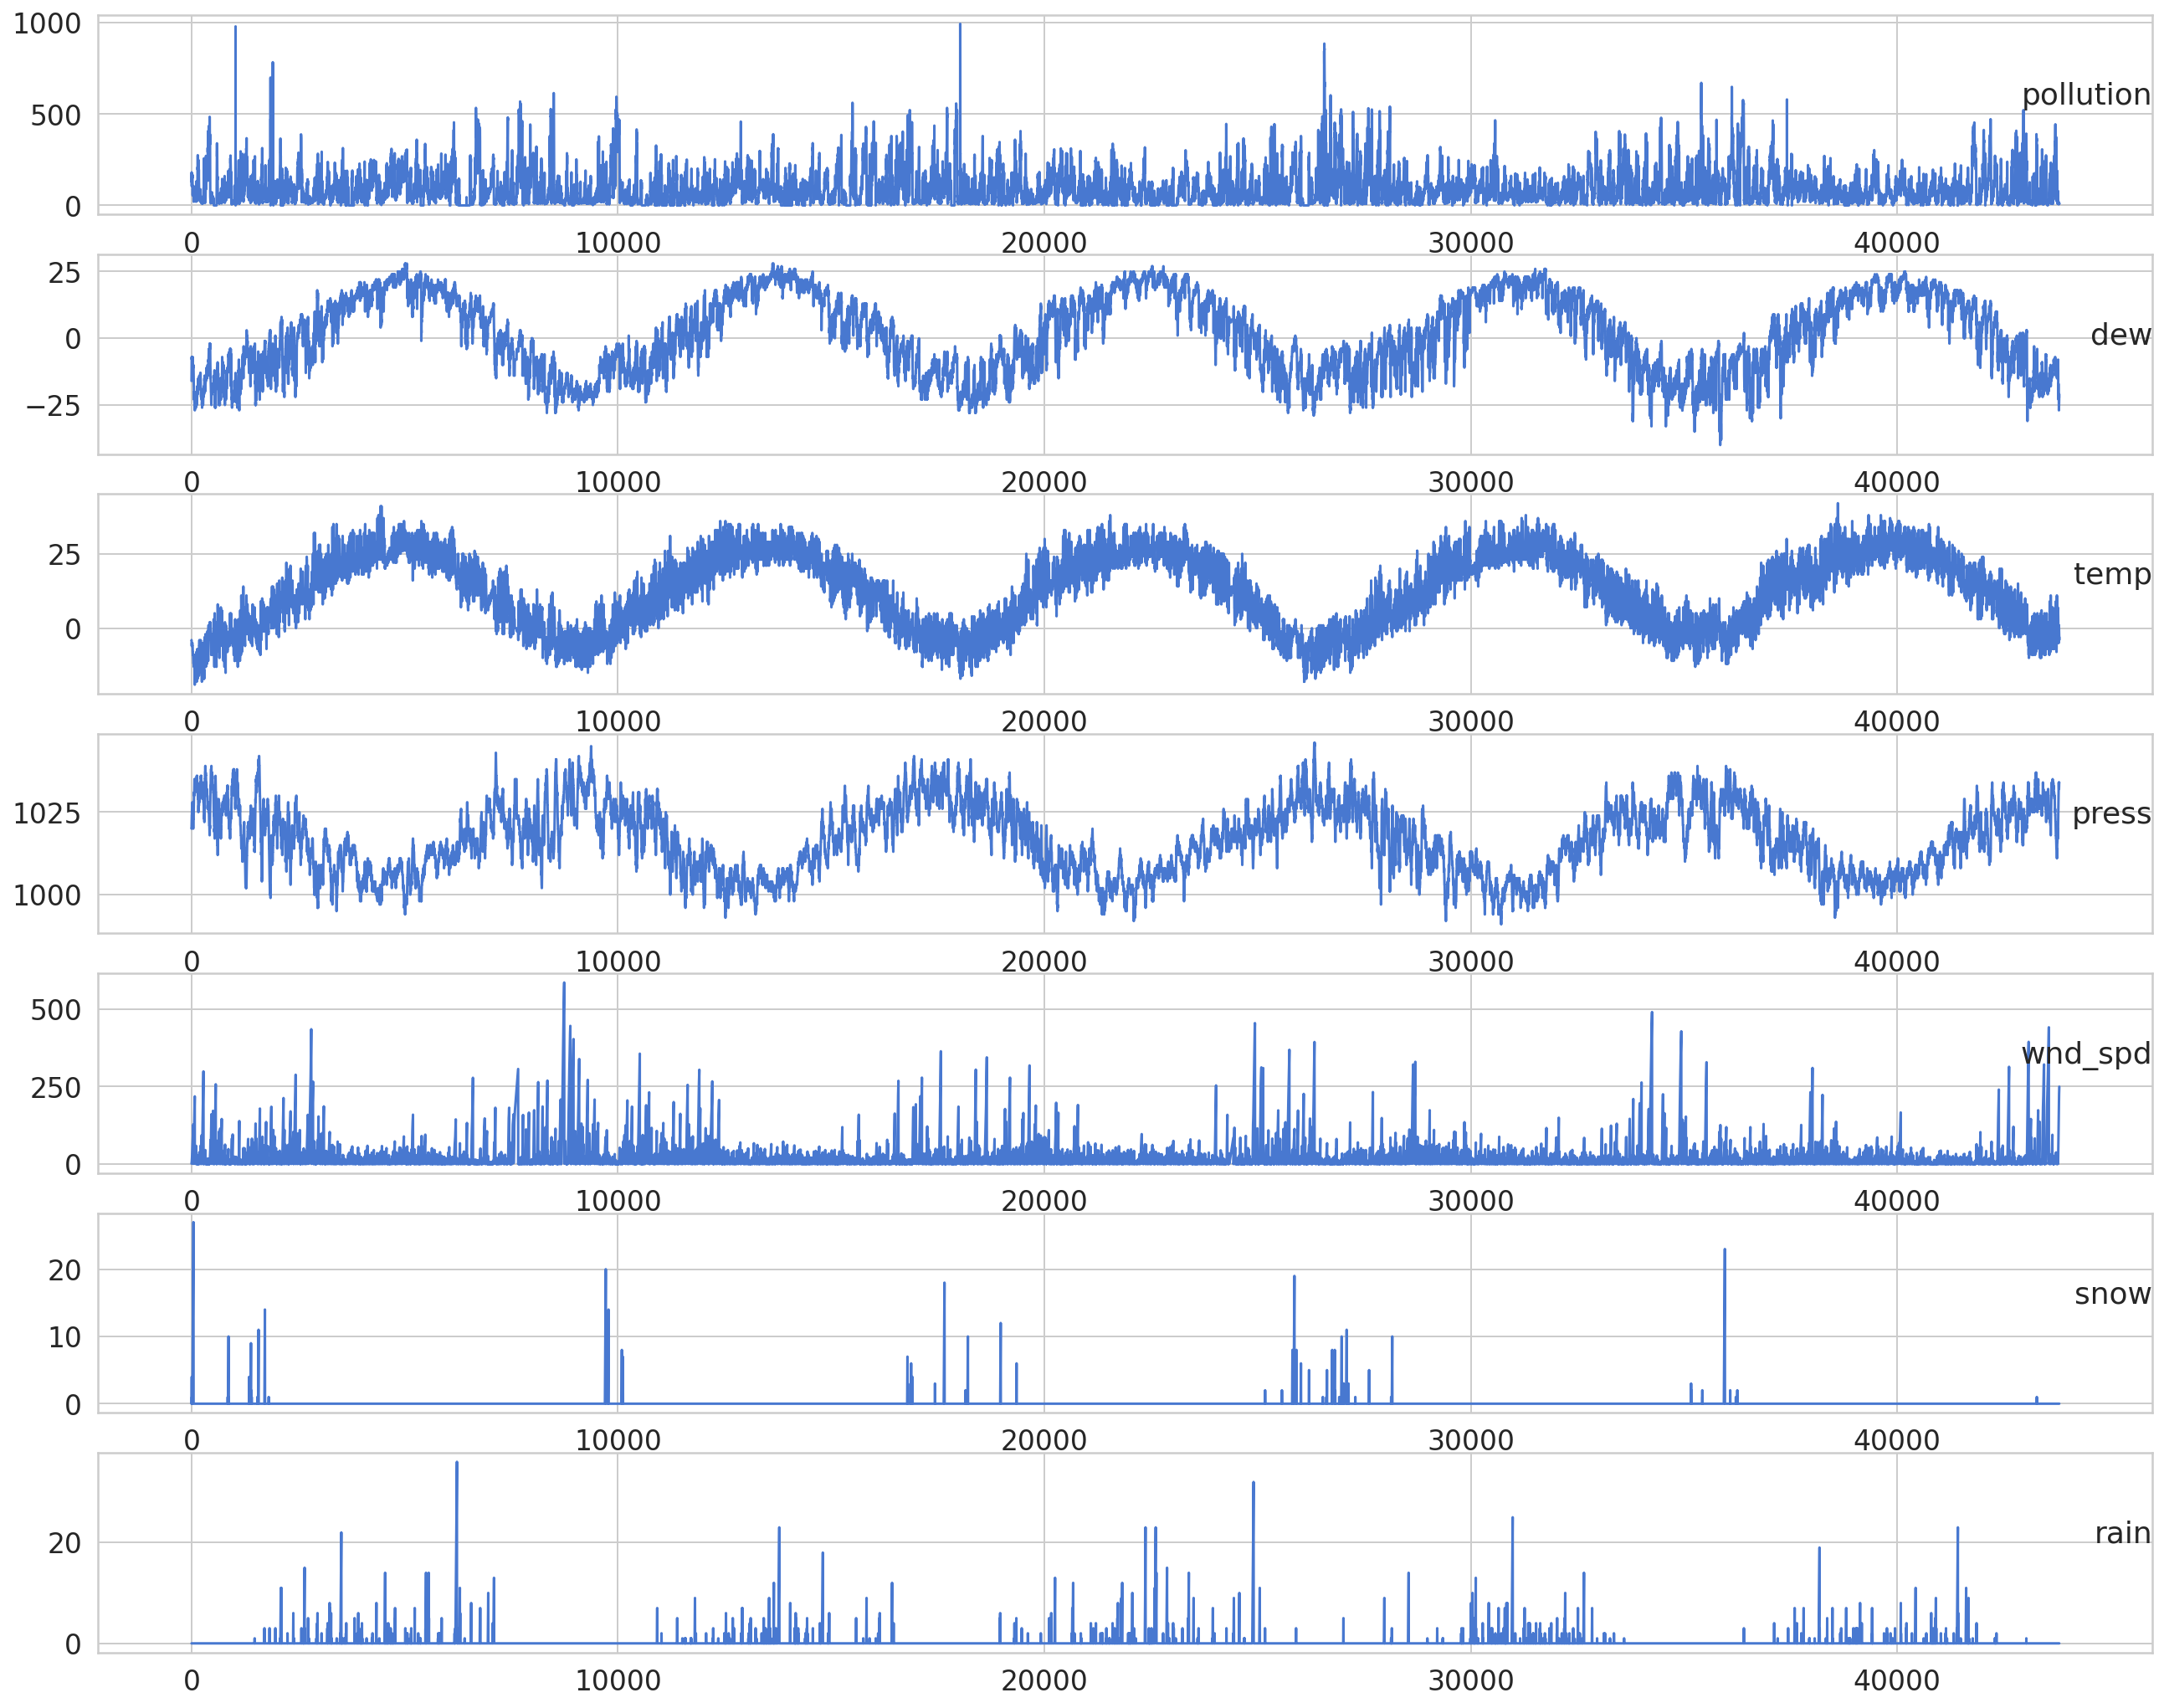

In [20]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [21]:
dataset.wnd_dir

date
2010-01-02 00:00:00    SE
2010-01-02 01:00:00    SE
2010-01-02 02:00:00    SE
2010-01-02 03:00:00    SE
2010-01-02 04:00:00    SE
                       ..
2014-12-31 19:00:00    NW
2014-12-31 20:00:00    NW
2014-12-31 21:00:00    NW
2014-12-31 22:00:00    NW
2014-12-31 23:00:00    NW
Name: wnd_dir, Length: 43800, dtype: object

In [22]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
dataset.wnd_dir =labelencoder.fit_transform(dataset.wnd_dir)
dataset

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,1,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,1,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,1,242.70,0,0


In [23]:
dataset.isnull().sum()


pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [24]:
dataset.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow',
       'rain'],
      dtype='object')

In [25]:
target = dataset.filter(["pollution"])

In [26]:
feature_columns = ['dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [27]:
time_steps = 60
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size], dataset.iloc[train_size:len(dataset)]
print(len(train), len(test))

35040 8760


In [28]:
from sklearn.preprocessing import RobustScaler

f_transformer = RobustScaler()
t_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
t_transformer = f_transformer.fit(train[["pollution"]])

train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train['pollution'] = t_transformer.transform(train[['pollution']])

test.loc[:,feature_columns]= f_transformer.transform(test[feature_columns].to_numpy())
test['pollution'] = t_transformer.transform(test[['pollution']])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [29]:
train

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.568807,-0.761468,-0.651376,8.743119,-0.596330,-0.598257,-0.614679,-0.614679
2010-01-02 01:00:00,0.743119,-0.752294,-0.651376,8.743119,-0.596330,-0.590092,-0.614679,-0.614679
2010-01-02 02:00:00,0.844037,-0.715596,-0.660550,8.752294,-0.596330,-0.581927,-0.614679,-0.614679
2010-01-02 03:00:00,1.045872,-0.678899,-0.660550,8.761468,-0.596330,-0.565505,-0.605505,-0.614679
2010-01-02 04:00:00,0.651376,-0.678899,-0.660550,8.761468,-0.596330,-0.557339,-0.596330,-0.614679
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,-0.412844,-0.788991,-0.550459,8.678899,-0.605505,0.439174,-0.614679,-0.614679
2013-12-31 20:00:00,-0.449541,-0.807339,-0.550459,8.688073,-0.605505,0.484312,-0.614679,-0.614679
2013-12-31 21:00:00,-0.403670,-0.807339,-0.550459,8.688073,-0.605505,0.537615,-0.614679,-0.614679


In [30]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range (len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
test_data = dataset[train_size - time_steps:]

def create_dataset_test(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range (test_size):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [32]:

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.pollution, time_steps)
X_test, y_test = create_dataset_test(test_data, test_data.pollution, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(34980, 60, 8) (34980,)
(8760, 60, 8) (8760,)


In [33]:
model = Sequential()
model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))))
model.add(LSTM(32))
model.add(Dense(units=1))
model.compile(loss="mean_squared_error", optimizer = "adam")
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
with tf.device('device:GPU:0'):
    history = model.fit(
      X_train, y_train,
      epochs=30,
      batch_size=4,
      validation_split=0.2,
      callbacks=[callback],
      shuffle=False
    )

Epoch 1/30
6996/6996 [==============================] - 70s 10ms/step - loss: 0.1098 - val_loss: 0.0418
Epoch 2/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0746 - val_loss: 0.0431
Epoch 3/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0736 - val_loss: 0.0398
Epoch 4/30
6996/6996 [==============================] - 69s 10ms/step - loss: 0.0680 - val_loss: 0.0396
Epoch 5/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0668 - val_loss: 0.0387
Epoch 6/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0673 - val_loss: 0.0420
Epoch 7/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0656 - val_loss: 0.0391
Epoch 8/30
6996/6996 [==============================] - 68s 10ms/step - loss: 0.0667 - val_loss: 0.0388
Epoch 9/30
6996/6996 [==============================] - 69s 10ms/step - loss: 0.0657 - val_loss: 0.0385
Epoch 10/30
6996/6996 [==============================] - 68s 10m

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = t_transformer.inverse_transform(y_train.reshape(-1,1))
y_test_inv = t_transformer.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = t_transformer.inverse_transform(y_pred)

In [ ]:
y_test_inv.shape, y_pred_inv.shape

In [ ]:
train_data = target[:train_size]
valid = target[train_size:]
valid['Predictions'] = y_pred_inv

In [ ]:
valid

In [ ]:
rmse=np.sqrt(np.mean(((y_pred_inv - y_test_inv)**2)))
rmse

In [ ]:
valid.plot();